# Assignment 2a Notebook: Automated Design of AI Agents with Random Search
Assignment series 2 will cover the design of AI agents with random search, the design of AI agents with genetic programming (GP), and the competitive co-evolution of GP agents with challenging maps. In this notebook, we'll lay the foundation for implementing agent design with GP by implementing random search (i.e., the initialization you'll eventually use for GP). Unlike the previous random search assignment, however, we have opted to leave the specifics of how to implement the parse tree genotype as an open problem for you to solve.

To begin the assignment, execute the following cell to set up the notebook and define a helper function we'll use later on.

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from snake_eyes import read_config
from fitness import play_GPac
from gpac import render_start

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('The first cell has been executed!')

The first cell has been executed!


## GPac
In this assignment series, we'll be playing GPac: a game inspired by Ms. Pac-Man but using simplified mechanics. To make this assignment more about your ability to understand and implement search algorithms, we're providing you with an implementation of GPac with some stock agents. Below is a function call to the main fitness function of this assignment series. The parameters passed in this demo result in a game where agents select random valid moves and compete on the provided map. The returned values are the pac-man score and a log of the game. We'll visualize the first frame of the game, so you can get an idea of the scenario.

The Pac-Man's score was 16 and the log was written to worldFiles/notebooktest.txt


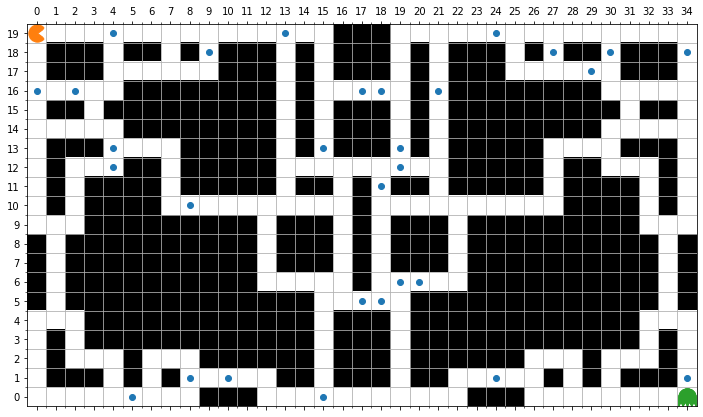

In [6]:
score, log = play_GPac(None, game_map='./maps/map00.txt')
game_log_path = 'worldFiles/notebooktest.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in log]

print(f"The Pac-Man's score was {score} and the log was written to {game_log_path}")

render_start(log)

You can now upload the file found at `worldFiles/notebooktest.txt` to [this visualizer](http://bonsai.auburn.edu/dtauritz/courses/ec/intro/2020fall/visualizer.html) to watch the full game.

## Problem Formulation
Now that you've seen a game played by an agent that makes random actions, let's talk about how more intelligent AI agents will work in GPac. When an agent makes a move in GPac, it knows the outcome of its action. The agent doesn't necessarily know what actions its opponent(s) will make during the same turn, but we'll ignore that in this assignment series and consider only the outcome of an agent's immediate actions.

When stated more formally, for a given state $s$ and its corresponding action space $A(s)$, we know all valid actions, $a\in A(s)$, and the resultant state from executing any of these actions, $s(a) \to s'$. In this assignment series, you will automate the design of a value function $V(s')$ that approximates the value/utility of being in a particular state $s'$. The agent will select a valid action using one of the greedy policies $argmax_a (V(s'))$ or $argmin_a (V(s'))$. That is, for each state, the agent will choose whichever action leads to the best next state according to its value function $V$. This value function is what we will be using GP to design.

In less formal terms, you are searching for a function to score how desirable a given state is. The action made by the agent is that which produces either the highest or lowest score (feel free to experiment and see which approach performs better).

#### Note:
You may see the value function $V$ used in reinforcement learning literature to denote a function that calculates the expected future reward of a given policy. We are not strictly adhering to that definition in this assignment series, though the underlying goal of finding a performant agent is the same.


## GPac Parse Trees
The functions you generate will be in the form of parse tree expressions consisting of primitives. Primitives consist of sensor inputs that extract useful information from the state $s'$, and operators, that perform operations on one or more input values. Input sensors and operators are also sometimes called leaf/terminal nodes and internal/function nodes, respectively. Parse trees are executed by performing a depth first in-order traversal. As an example, the function $V(s') =$ `(1.2/G)*RAND(W,P)` would be represented as the following parse tree:
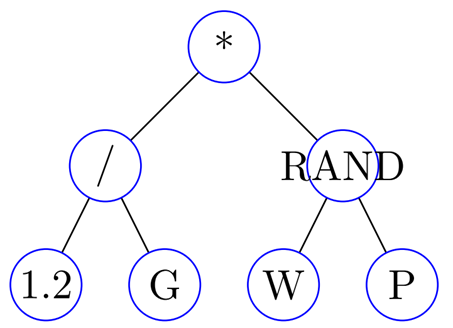

When represented in the output format prescribed in the assignment description, this example parse tree appears as follows:
```
*
|/
||1.2
||G
|RAND
||W
||P
```

The required sensor/terminal primitives for this assignment are as follows:
* sensor inputs
 * G - Manhattan distance to nearest ghost
 * P - Manhattan distance to nearest pill
 * W - Number of immediately adjacent walls
 * F - Manhattan distance to nearest fruit
 * #.# - Constant value (with an optional leading '-' for negatives, and where the '#' character is replaced with one or more digits)

**Notes**: All of the distance calculations treat the board as if there are no walls (i.e., you don't need to worry about walls in your search algorithm). The borders of the map are considered walls for the purpose of the W primitive, and the W primitive only counts walls in the four cardinal directions. If there is no fruit on the board, the F primitive should return the same value for any state.

The required operator/function primitives for this assignment are as follows:
* operators
 * +
 * -
 * *
 * /
 * RAND - Random number between the two children node values

**Notes**: All of the above operators should have strictly two children. Dividing by zero must gracefully produce valid output using an algorithm of your choice. Keep in mind that floating-point numbers have a fixed range in Python, and you need to account for this in your operations.

## Implementing The Parse Tree Genotype
Recall that in this assignment, it is up to you to implement the parse tree gene representation as an open-ended problem. This assignment will focus on generating and executing trees, but keep in mind that the **next assignment** will have you recombine and mutate trees as well. Your parse tree implementation for this assignment should be able to create parse trees with the grow and full methods, print trees as strings using the format prescribed in the assignment description, and execute parse trees to evaluate a state $s'$. The details of these requirements will be discussed momentarily and we informally recommend the implementation of tree generation with dummy primitives followed by the implementation of tree execution. However, this assignment is open-ended and you are encouraged to implement the required functionality in the order that is most logical *to you*. As such, you are welcome to complete parts of this notebook section out of order so long as the notebook runs from beginning to end when we evaluate your assignment.

**We strongly recommend that you implement your parse tree gene representation as a new class.** An object instance of your new class will later be assigned to the `gene` member variable of the provided `TreeGenotype` class. You are welcome to define your tree class in the `tree_genotype.py` file since your representation class could be tightly coupled with the provided `TreeGenotype` class. If you wish to define your class in a new file, however, please import your file in the following cell. To be clear, the `gene` variable will be the entire parse tree, analogous to the coordinate pairs from Assignment Series 1.

In [145]:
from tree_genotype import *
# import your Python class here if it's in a different file


### The Full Method for Tree Initialization
Assume we have a set of operator primitives $F$, a set of sensor input primitives $T$, and an initial depth limit $D_{max}$. In the full method, each branch of the tree has depth $D_{max}$. The contents of nodes at depth $d$ are chosen from $F$ if $d<D_{max}$ or from $T$ if $d=D_{max}$ [1].

In less formal terms, you create a tree by selecting random operator nodes until you reach the depth limit. Once you reach the depth limit, you select random sensor input primitives. This produces full trees where each branch reaches the depth limit.

Implement the full method in your .py file, then call it in the next cell to instantiate a tree.

In [23]:
depth = 5
# Instantiate a tree object with your full method

val_func = ValueFunction(depth)
val_func.full_init()

print(val_func.print())

del depth

*
|-
||RAND
|||-
||||W
||||-5.31795173411838
|||RAND
||||G
||||W
||/
|||*
||||P
||||W
|||+
||||P
||||G
|+
||+
|||+
||||P
||||P
|||-
||||P
||||5.295763756461598
||-
|||/
||||P
||||F
|||/
||||W
||||G


### The Grow Method for Tree Initialization
Like the full method, assume we have a set of operator primitives $F$, a set of sensor input primitives $T$, and an initial depth limit $D_{max}$. In the grow method, however, The contents of nodes at depth $d$ are chosen from $F \cup T$ if $d<D_{max}$ or from $T$ if $d=D_{max}$ [1].

In less formal terms, you create a tree by randomly selecting an operator *or* sensor input primitive if above the depth limit. If at the depth limit, you select random sensor input primitives. This produces trees with less uniform branch depth than the full method since branches can terminate before the depth limit if a node is selected to contain a sensor input primitive.

**Tip**: if you call this method on a node within an existing tree, it can perform an acceptable mutation operation.

Implement the grow method in your .py file, then call it in the next cell to instantiate a tree.

In [184]:
depth = 5
# Instantiate a tree object with your grow method

val_func = ValueFunction(depth)
val_func.grow_init()

print(val_func.print())

del depth

*
|-
||+
|||P
|||RAND
||||F
||||W
||P
|*
||F
||P


### Population Initialization with Ramped Half-And-Half
Now that the grow and full methods are implemented, you have the necessary components to implement ramped half-and-half population initialization. In ramped half-and-half, half of the population is initialized with the grow method and the other half with the full method. Implement the `initialization` class method of the `TreeGenotype` class in `tree_genotype.py` such that the `gene` member variable of each individual in the population is assigned a tree using the ramped half-and-half method.

Once implemented, execute the following cell to call your ramped half-and-half implementation.

In [189]:
config = read_config('./configs/green2a_config.txt', globalVars=globals(), localVars=locals())
example_population = TreeGenotype.initialization(50, **config['initialization_kwargs'])

print('Number of uninitialized individuals: ' \
      + f'{len([individual.gene for individual in example_population if individual.gene is None])}')

del config
del example_population

Number of uninitialized individuals: 0


### Printing Trees
When working with GP parse trees, it's tremendously valuable to visualize your trees and the equations/programs they encode. In the assignment description document, we prescribe a format for expressing your parse trees in text. Implement the `print` method of the `TreeGenotype` class to return a string representation of your tree in the prescribed format.

Once implemented, execute the following cell and manually inspect some small trees for obvious errors.

In [193]:
example_population = TreeGenotype.initialization(5, depth_limit=3)

for idx, individual in enumerate(example_population):
    print(f"Individual {idx}'s tree:")
    print(individual.print())
del example_population

Individual 0's tree:
/
|G
|6.271103663948004
Individual 1's tree:
G
Individual 2's tree:
-
|/
||W
||P
|+
||8.129366410127794
||F
Individual 3's tree:
-
|RAND
||P
||W
|/
||F
||G
Individual 4's tree:
-
|8.277591933987576
|P


### Automated Tree Assessment
Now that you've done some light manual testing, let's perform some automated testing at scale using a tool that examines trees from files. Execute the following cell to generate 100 trees of depth 10 that will be subjected to automated assessment.

In [194]:
example_population = TreeGenotype.initialization(100, depth_limit=10)

for idx, individual in enumerate(example_population):
    with open(f'treeTests/tree{idx}.txt','w') as f:
        f.write(individual.print())
del example_population
!python tree_check.py treeTests/tree*.txt

treeTests/tree0.txt: PASS
treeTests/tree1.txt: PASS
treeTests/tree10.txt: PASS
treeTests/tree11.txt: PASS
treeTests/tree12.txt: PASS
treeTests/tree13.txt: PASS
treeTests/tree14.txt: PASS
treeTests/tree15.txt: PASS
treeTests/tree16.txt: PASS
treeTests/tree17.txt: PASS
treeTests/tree18.txt: PASS
treeTests/tree19.txt: PASS
treeTests/tree2.txt: PASS
treeTests/tree20.txt: PASS
treeTests/tree21.txt: PASS
treeTests/tree22.txt: PASS
treeTests/tree23.txt: PASS
treeTests/tree24.txt: PASS
treeTests/tree25.txt: PASS
treeTests/tree26.txt: PASS
treeTests/tree27.txt: PASS
treeTests/tree28.txt: PASS
treeTests/tree29.txt: PASS
treeTests/tree3.txt: PASS
treeTests/tree30.txt: PASS
treeTests/tree31.txt: PASS
treeTests/tree32.txt: PASS
treeTests/tree33.txt: PASS
treeTests/tree34.txt: PASS
treeTests/tree35.txt: PASS
treeTests/tree36.txt: PASS
treeTests/tree37.txt: PASS
treeTests/tree38.txt: PASS
treeTests/tree39.txt: PASS
treeTests/tree4.txt: PASS
treeTests/tree40.txt: PASS
treeTests/tree41.txt: PASS
treeTe

## Fitness Evaluation
In this assignment, we're leaving part of the fitness function for you to implement as you need to interface your custom tree genotype implementation. In Assignment 2c, we'll be performing competitive co-evolution with multiple controllers. For assignments 2a and 2b though, your Pac-Man agents will play against a provided ghost agent that selects random moves.

### State Dictionaries
The interface between your parse tree and the game is through a list of state dictionaries. This list represents the space of valid $s'$ states resulting from Pac-Man's possible actions. Each $s'$ state is represented by one of the state dictionaries. The state dictionaries contain all the information about the game necessary for your parse tree's sensor inputs. Execute the following cell to see an example of what a state dictionary looks like. Note that the walls of the map are rotated when printed, but they use an `[x][y]` indexing scheme.

In [195]:
# TODO: refactor this
import gpac
from fitness import parse_map

config = read_config('./configs/green2a_config.txt', globalVars=globals(), localVars=locals())

# Ignore these next 2 lines
game_map = parse_map(config['fitness_kwargs']['game_map'])
game = gpac.GPacGame(game_map, **{key:value for key, value in config['fitness_kwargs'].items() if key != 'game_map'})

# The following lines are the focus of this demo
actions = game.get_actions()
s_primes = game.get_observations(actions)
for k, v in s_primes[0].items():
    if isinstance(v, list):
        print(k)
        for line in v:
            print(line)
    else:
        print("{}: {}".format(k, v))
        
del game, game_map, config

walls
[0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0]
[0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0]
[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0,

### Tree Execution
Regardless of how you've implemented your trees so far, they must accept as input a state dictionary and return as output a floating point number representing the tree's score for that state. Using this score, you will select the index of the action with the best score as determined by the greedy policy mentioned at the begining of the notebook. In whatever order you like, implement your tree execution functionality and the portion of `play_GPac` in `fitness.py` where you use your genotype to score states and select an action. The `play_GPac` function expects as input a `pac_controller` object in addition to other parameters in your config file. The object you pass in for the controller could either be a gene object itself (like we did for map evaluation) or a `TreeGenotype` object with an initialized `gene` member variable you use inside the fitness function.

The implementation of tree execution and the fitness function is relatively open-ended and thus you may test the execution of your parse trees however you see fit. If you're feeling lost though, feel free to reference the Pac-Man GP Tree Implementation presentation given in class for some pseudocode and guidance. The easiest way to test your tree execution is most likely to implement single-node trees for each of your sensor input primitives and then perform a fitness evaluation using those.

**Note**: in addition to the execution method shown in class, GP can also be implemented by assigning the chosen function to a member variable of the nodes, as Python allows you to use functions as objects. This might be an advanced technique, but feel free to look closer at how the survival selection function was called in the Assignment Series 1 EA object class for an example of what this could look like.

Using the following cell, assign to `pac_controller` an object appropriate for your `play_GPac` implementation to play a full game. You are welcome to add additional tests to the following cell as well.

In [312]:
config = read_config('./configs/green2a_config.txt', globalVars=globals(), localVars=locals())

# TODO: assign pac_controller
pac_controller = ValueFunction(5).full_init()

fitness, log = play_GPac(pac_controller, **config['fitness_kwargs'])

# an example of game logging for use with the visualizer
game_log_path = 'worldFiles/2anotebooktest.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in log]

## Random Search Algorithm
By this point, your implementation of population initialization, tree printing, tree execution, and the fitness function should be complete. In the following cell, implement a single-run random search experiment by evaluating a population of 2,000 solutions. Be sure to keep track of the best solution seen so far!

In [369]:
from math import inf

def random_search(number_evaluations, config_filename):
    config = read_config(config_filename, globalVars=globals(), localVars=locals())
    
    data = {'best_fitness': -inf, 'log': None, 'member': None, 'points': []}
    
    # Make a random-enough population with ramped half-and-half
    random_population = TreeGenotype.initialization(number_evaluations, **config['initialization_kwargs'])
    
    for i, member in enumerate(random_population):
        fitness, log = play_GPac(member.gene, **config['fitness_kwargs'])
        
        if fitness > data['best_fitness']:
            data.update({
                'best_fitness': fitness,
                'log': log,
                'member': member.print()
            })
            data['points'].append((i, fitness))
            
    data['points'].append((i, data['best_fitness']))
            
    return data

# Calling your function to test things out
# results = random_search(100, './configs/green2a_config.txt')
# print(results['best_fitness'])
# game_log_path = 'worldFiles/demo.txt'
# with open(game_log_path, 'w') as f:
#     [f.write(f'{line}\n') for line in results['log']]
# print(results['member'].print())
# print(results['points'])

## Full Random Search Experiment
Using the code you've written so far, perform a 30-run experiment where each run consists of 2,000 fitness evaluations. Like Assignment 1a, for the run that produced the highest fitness, produce a stairstep plot demonstrating the progress of that run as it progressed. In addition to logged data from this experiment, also save the log and parse tree that produced the highest score of the entire experiment.

In [377]:
from datetime import datetime
from multiprocessing import Pool
from pathlib import Path
import shutil


NUMBER_OF_CORES = 4


def experiment(runs, evaluations, config_path):
    global run  # used to expose run method to top-level and enable multiprocessing
    
    config_path = Path(config_path)
    config_name = config_path.stem.replace("_config", "")
    data_dir = Path("./data") / config_name
    shutil.rmtree(data_dir, ignore_errors=True)
    
    data_dir.mkdir(exist_ok=True)
    
    # logging file displaying live run progress
    logging_file = open(data_dir / "logging.txt", "w")
    
    def run(i):
        logging_file.write(f"{datetime.now().strftime('%X')} Run {i:2d}: START\n")
        logging_file.flush()
        result = random_search(evaluations, str(config_path))
        logging_file.write(f"{datetime.now().strftime('%X')} Run {i:2d}: ENDED\n")
        logging_file.flush()
        return result

    with Pool(NUMBER_OF_CORES) as p:
        runs = p.map(run, list(range(runs)))

    logging_file.close()
    
    with open(data_dir / 'results.txt', 'w') as f:
        f.write('\n'.join(str(run['best_fitness']) for run in runs))
    
    best_run = max((run for run in runs), key=lambda x: x['best_fitness'])
    
    print(f'The fitness of the best solution is {best_run["best_fitness"]:,}')
    
    with open(Path('worldFiles') / f'{config_name}.txt', 'w') as f:
        [f.write(f'{line}\n') for line in best_run['log']]
        
    with open(Path('solutions') / f'{config_name}.txt', 'w') as f:
        f.write(best_run['member'])
        
    with open(data_dir / 'stairstep.txt', 'w') as f:
        f.write(str(best_run['points']))
        
    fig, ax = plt.subplots()
    ax.set_title("Best Random Search Fitness")
    ax.set_xlabel("Evaluations")
    ax.set_ylabel("Fitness")
    lines = ax.step(x=[point[0] for point in best_run['points']], y=[point[1] for point in best_run['points']])
    fig.savefig(data_dir / "stairstep.png")
    
    del run  # cleanup of global scope abuse

The fitness of the best solution is 175


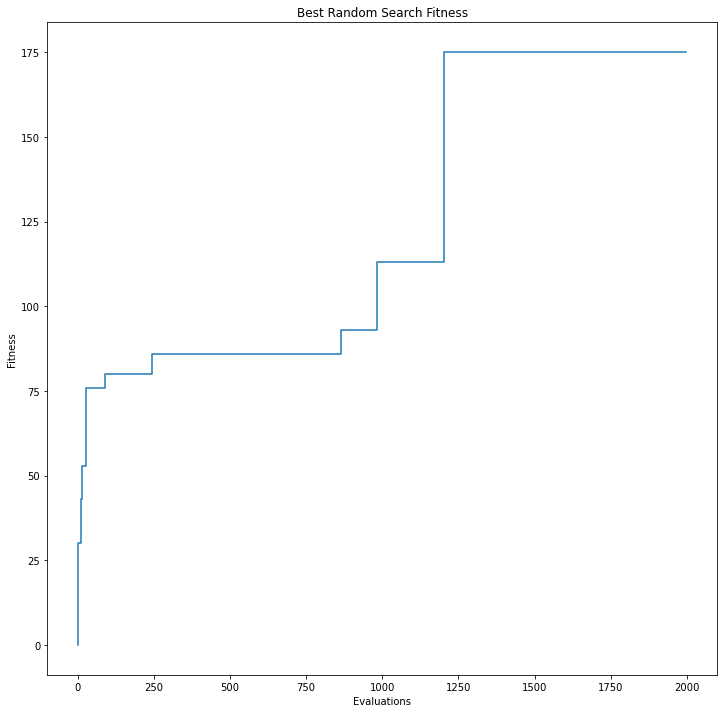

In [380]:
number_runs = 30
number_evaluations = 2000

config_filename = './configs/green2a_config.txt'

experiment(number_runs, number_evaluations, config_filename)

## Report
See the assignment description document.

## References
[1] A. E. Eiben and J. E. Smith, Introduction to Evolutionary Computing. Second Edition, Springer-Verlag,
Berlin Heidelberg, 2015, ISBN 978-3-662-44873-1